<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Общая-информация-о-датасете" data-toc-modified-id="Общая-информация-о-датасете-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Общая информация о датасете</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

**Цель проекта** - необходимо разработать для интернет-магазина «Викишоп» инструмент, который будет искать токсичные комментарии в описании товаров и отправлять их на модерацию. Нужно обучить модель классифицировать комментарии на позитивные и негативные на основе набора данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**В ходе выполнения проекта необходимо:**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделайть выводы.

Для выполнения проекта применять *BERT* необязательно.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 6.7 MB/s 
     |████████████████████████████████| 6.6 MB 46.7 MB/s 
     |████████████████████████████████| 101 kB 10.1 MB/s 


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re 
import random
import nltk
import time
import transformers
import warnings
from tqdm import notebook

from nltk.tokenize import word_tokenize, NLTKWordTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.svm import SVC

from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer=WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Общая информация о датасете

In [7]:
warnings.filterwarnings("ignore")

Откроем датасет и посмотрим на его основные свойства.

In [10]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/Data/toxic_comments.csv')
#data = pd.read_csv('drive/My Drive/Colab Notebooks/Data/toxic_comments.csv')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [12]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Датасет состоит из 159571 строк, данные находятся в двух столбцах. Первый содержит текст комментария на английском языке, второй - признак позитивности или негативности комментария.

Проверим, сбалансирован ли датасет по целевому признаку.

In [13]:
data['toxic'].value_counts() / len(data['toxic'])

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Токсичных комментариев в датасете - около 10%, датасет несбалансирован.

Посмотрим, какова максимальная и минимальная длина комментария, а также какой длины комментарии встречаются чаще всего.

In [14]:
lens = pd.DataFrame(data['text'].apply(lambda x: (len(x))).sort_values())
lens.describe()

,text
count,159571.000000
mean,394.073221
std,590.720282
min,6.000000
25%,96.000000
50%,205.000000
75%,435.000000
max,5000.000000


Комментарии имеют длину от 6 до 5000 символов, наиболее часто встречаются комментарии длиной около 200 символов.

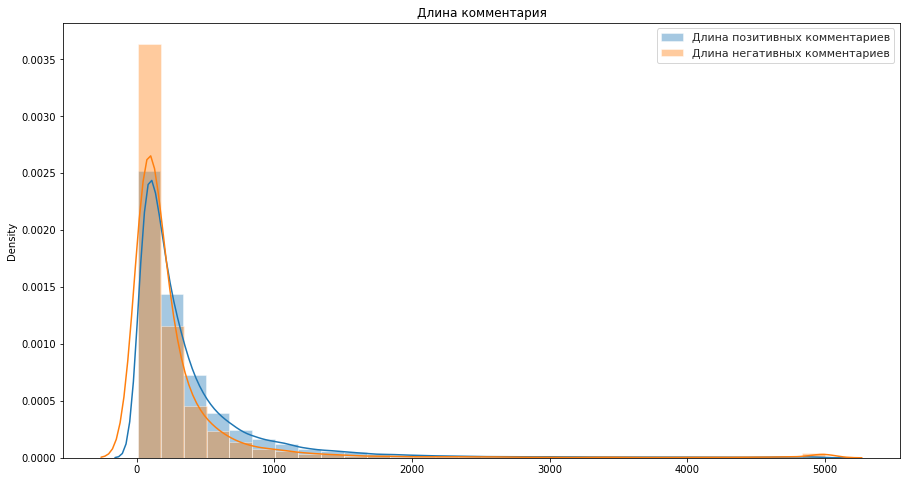

In [15]:
f, axs = plt.subplots(1, figsize=(15, 8))

sns.set(context='notebook', style='whitegrid')

sns.distplot(lens.loc[data['toxic']==0],  bins=30, label='Длина позитивных комментариев') 
sns.distplot(lens.loc[data['toxic']==1],  bins=30, label='Длина негативных комментариев') 

title = "Длина комментария"
plt.title(title)
plt.legend()
plt.show()

 Из графика видно, что негативные комментарии чаще немного короче позитивных, но в целом и для тех, и для других более короткие комментарии встречаются чаще длинных.

In [16]:
#indexes_0 = random.sample(list(data.loc[data['toxic']==0].index), k=5000)

In [17]:
#indexes_1 = random.sample(list(data.loc[data['toxic']==1].index), k=5000)

In [18]:
#indexes = indexes_0 + indexes_1

In [19]:
#indexes

In [20]:
#data = data.loc[indexes]

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [22]:
stopwords =  set(open('drive/My Drive/Colab Notebooks/Data/nltk_data/corpora/stopwords 2/english').read().split())

In [23]:
def process_text(s):
    s = s.lower()
    s = re.sub(r"[\\\']", " ", s)
    words = [re.sub(r"[\W,\d]", " ", word) for word in word_tokenize(s)  if word not in stopwords]
    words = [lemmatizer.lemmatize(word) for word in words if word != ""]
    words = [word for word in words if word not in stopwords]
    return  " ".join(words)

In [24]:
process_text(data.iloc[0]["text"])

'explanation edits made username hardcore metallica fan reverted   vandalism   closure gas voted new york doll fac   please remove template talk page since retired now             '

In [25]:
data.iloc[0]['text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [26]:
%%time
data['text_cl'] = data["text"].apply(lambda x: process_text(x))

CPU times: user 2min 23s, sys: 503 ms, total: 2min 23s
Wall time: 2min 25s


In [27]:
data

,text,toxic,text_cl
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constan...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wondered...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,second time asking view complet...
159567,You should be ashamed of yourself \n\nThat is ...,0,ashamed horrible thing put talk page ...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm actual article prostitution ring...
159569,And it looks like it was actually you who put ...,0,look like actually put speedy first version de...


Данные очищены и готовы к использованию для обучения модели.

In [28]:
data_cl = data.drop('text', axis=1)

In [29]:
data_cl = data_cl.dropna()

In [30]:
data_cl

,toxic,text_cl
0,0,explanation edits made username hardcore metal...
1,0,aww match background colour seemingly stuck ...
2,0,hey man really trying edit war guy constan...
3,0,make real suggestion improvement wondered...
4,0,sir hero chance remember page
...,...,...
159566,0,second time asking view complet...
159567,0,ashamed horrible thing put talk page ...
159568,0,spitzer umm actual article prostitution ring...
159569,0,look like actually put speedy first version de...


In [31]:
vectorizer = TfidfVectorizer(ngram_range = (1, 1))

In [32]:
X = vectorizer.fit_transform(data_cl['text_cl'])

In [33]:
X

<159571x169240 sparse matrix of type '<class 'numpy.float64'>'
	with 4290124 stored elements in Compressed Sparse Row format>

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, data_cl["toxic"], stratify=data_cl["toxic"])

## Обучение и подбор модели

### Логистическая регрессия

Попробуем решить задачу классификации твиттов с использованием простой логистической регрессии. Так как выборка несбалансирована по целевому признаку, используем параметр class_weight. Подбор гиперпараметром модели будем проводить с помощью  метода GridSearchCV, в качестве метрики оценки качества при подборе модели установим f1-score. Параметрами для перебора будут метод решения solver и переметр регуляризации С. Количество фолдов для кроссвалидации снова установим равным 5.

In [35]:
clf_lg = LogisticRegression(random_state=123456, class_weight='balanced')

In [ ]:
lg_params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'C': [np.arange(0, 15), 20, 30, 50, 100]
              }

In [ ]:
%%time
lg_grid = GridSearchCV(clf_lg, lg_params, scoring='f1', refit='f1',
                         cv=5, return_train_score=True, n_jobs=-1)
lg_grid.fit(X_train, y_train)
print(lg_grid.best_score_)
print(pd.DataFrame(confusion_matrix(y_train, lg_grid.predict(X_train)),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7620697242258585
     pred_neg  pred_pos
neg    105930      1579
pos        38     12131
CPU times: user 26 s, sys: 4.26 s, total: 30.2 s
Wall time: 6min 46s


In [ ]:
lg_grid.best_params_

{'C': 20, 'solver': 'newton-cg'}

Получили модель логистической регрессии с параметром регуляризации, который точно равен одному из значений, заданному нами в параметрах, оптимальный параметр регуляризации может находиться в диапазоне между соседними числами. Запустим подбор повторно с другим диапазоном для C

In [ ]:
lg_params = {'solver': [lg_grid.best_params_['solver']],
              'C': np.arange(lg_grid.best_params_['C']-5, 
                             lg_grid.best_params_['C']+5)
              }

In [ ]:
%%time
lg_grid = GridSearchCV(clf_lg, lg_params, scoring='f1', refit='f1',
                         cv=5, return_train_score=True, n_jobs=-1)
lg_grid.fit(X_train, y_train)
print(lg_grid.best_score_)
print(pd.DataFrame(confusion_matrix(y_train, lg_grid.predict(X_train)),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

0.763746674231649
     pred_neg  pred_pos
neg    105699      1810
pos        45     12124
CPU times: user 24 s, sys: 3.28 s, total: 27.3 s
Wall time: 3min 31s


In [ ]:
lg_grid.best_params_

{'C': 15, 'solver': 'newton-cg'}

Сохраним полученные результаты.

In [ ]:
results = pd.DataFrame()
results = results.append({
    'model':'Логистическая регрессия', 
    'f1-score': lg_grid.best_score_
}, ignore_index=True )

In [ ]:
prediction_lg = lg_grid.predict(X_test)

In [ ]:
print('Метрики классификации логистической регрессией')
print()
print(classification_report(y_test, prediction_lg))

Метрики классификации логистической регрессией

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     35837
           1       0.73      0.80      0.76      4056

    accuracy                           0.95     39893
   macro avg       0.85      0.88      0.87     39893
weighted avg       0.95      0.95      0.95     39893



Получили модель, оценивающую токсичность комментарий с точностью 95% по метрике f1. Модель отлично определяет нетоксичные комментарии и с меньшей точностью - негативные.

### Метод опорных векторов

Попробуем решить задачу классификации твиттов с использованием метода опорных векторов и классификатора SVC. Так как выборка несбалансирована по целевому признаку, используем параметр class_weight.

In [ ]:
clf_SVC = SVC(class_weight='balanced')

Проверку качества модели будем проводить на отложенной выборке, для этого разделим тренировочный датасет на обучающий и валидационный.

In [ ]:
X_train_SVN, X_val_SVN, y_train_SVN, y_val_SVN = train_test_split(X_train, y_train, stratify=y_train)

In [ ]:
%%time
clf_SVC.fit(X_train_SVN, y_train_SVN)

CPU times: user 43min 34s, sys: 10.8 s, total: 43min 45s
Wall time: 43min 54s


SVC(class_weight='balanced')

Проверим качество полученной модели.

In [ ]:
prediction = clf_SVC.predict(X_val_SVN)

In [ ]:
f1_SVC = f1_score(y_val_SVN, prediction)

In [ ]:
print('Метрики классификации')
print()
print(classification_report(y_test, clf_SVC.predict(X_test)))

Метрики классификации

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     35837
           1       0.86      0.69      0.77      4056

    accuracy                           0.96     39893
   macro avg       0.91      0.84      0.87     39893
weighted avg       0.96      0.96      0.96     39893



Сохраним полученные результаты.

In [ ]:
results = results.append({
    'model':'Метод опорных векторов', 
    'f1-score': f1_SVC
}, ignore_index=True )

### Классификация с CatBoost

In [ ]:
clf_cat = CatBoostClassifier(auto_class_weights='Balanced', iterations=10)

In [ ]:
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_train, y_train, stratify=y_train)

In [ ]:
%%time
clf_cat.fit(X_train_cat,y_train_cat,verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 1h 18min 28s, sys: 49.5 s, total: 1h 19min 17s
Wall time: 14min 5s


Проверим качество полученной модели.

In [ ]:
prediction = clf_cat.predict(X_val_cat, prediction_type='Class')

In [ ]:
f1_cat = f1_score(y_val_cat, prediction)
f1_cat

0.7570093457943925

In [ ]:
cat_params = {'learning_rate': [0.03, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [ ]:
%%time
cat_grid = clf_cat.grid_search(cat_params, X=X_train,y=y_train, cv=3, stratified=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
cat_grid

NameError: name 'cat_grid' is not defined

In [ ]:
print('Метрики классификации')
print()
print(classification_report(y_test, clf_cat.predict(X_test)))

Метрики классификации

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     35837
           1       0.70      0.82      0.75      4056

    accuracy                           0.95     39893
   macro avg       0.84      0.89      0.86     39893
weighted avg       0.95      0.95      0.95     39893



Сохраним полученные результаты.

In [ ]:
results = results.append({
    'model':'Градиентный бустинг', 
    'f1-score': f1_cat
}, ignore_index=True )

In [ ]:
results

,model,f1-score
0,Логистическая регрессия,0.763747
1,Метод опорных векторов,0.761156
2,Градиентный бустинг,0.757009


### Классификация с использованием модели BERT

Применим для решения задачи классификации твиттов модель BERT. Так как выборка несбалансирована по целевому признаку, используем параметр class_weight.

### Сравнение с предсказанием по наиболее популярному токену

Иногда в текстах можно обнаружить слово или символ (например, ")" может обозначат улыбающийся смайлик), который один может обеспечивать достаточно точную классификацию текста по его тональности. Попробуем найти несколько самых значимых для классификации токенов в исходном тексте.

In [ ]:
coeff = sorted(clf_lg.coef_[0], reverse=True)[:30]

In [ ]:
max_indexes = []
for i in coeff:
    max_indexes.append(list(clf_lg.coef_[0]).index(i))

In [ ]:
cool_tokens = []
for index in max_indexes:
    for v in list(vectorizer.vocabulary_.items()):
        if v[1] == index:
            cool_tokens.append(v[0])

In [ ]:
cool_tokens

['fuck',
 'fucking',
 'idiot',
 'shit',
 'stupid',
 'suck',
 'asshole',
 'bitch',
 'bullshit',
 'dick',
 'crap',
 'faggot',
 'moron',
 'cunt',
 'penis',
 'bastard',
 'hell',
 'pathetic',
 'jerk',
 'loser',
 'dumb',
 'gay',
 'nigger',
 'fucked',
 'cock',
 'shut',
 'fucker',
 'fag',
 'dumbass',
 'ignorant']

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data['text'], data["toxic"], stratify=data["toxic"])

In [ ]:
preds = []

for text in X_test_2:
    pred = 0
    for token in cool_tokens:
        if token in text:
            pred = 1
    preds.append(pred)

In [ ]:
print(classification_report(preds, y_test_2))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     36381
           1       0.56      0.64      0.60      3512

    accuracy                           0.92     39893
   macro avg       0.76      0.80      0.78     39893
weighted avg       0.93      0.92      0.93     39893



In [ ]:
f1_score(preds, y_test_2)

0.59830866807611

Получили точность предсказания на тестовой выборке в 93%, просто ориентируясь на наличие в тексте 20 самых популярных нецензурных слов. При этом нетоксичные комментарии получается отсеивать с 96%точностью по метрике f1. Токсичные комментарии фильтруются хуже - с точностью 58% по метрике f1. Чем выше количество фиксируемых нецензурных слов, тем эффективнее такая константная модель будет находить токсиные комментарии, но будет захватывать при этом часть нетоксичных. Модель может быть настроена изменением словаря cool_tokens. При этом скорость работы такой модели несопоставимо ниже любых моделей машинного обучения.

Попробуем токенайзер NLTKWordTokenizer

In [ ]:
tok = NLTKWordTokenizer()

In [ ]:
text = tok.span_tokenize(data['text'])

AttributeError: 'generator' object has no attribute 'head'

### Класификация с использованием униграмм символов

Предположим, что на общую тональность текста значительное влияние оказывают символы (например, обозначаюьщие смайлы и др.) Попробуем провести векторизацию исходного текста с учетом только символов.

In [ ]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1), stop_words= stopwords)
data_cv = vec.fit_transform(X_train_2)
clf = LogisticRegression(random_state=123456)
clf.fit(data_cv, y_train_2)
pred_cv = clf.predict(vec.transform(X_test_2))
print(classification_report(pred_cv, y_test_2))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     39503
           1       0.07      0.72      0.13       390

    accuracy                           0.90     39893
   macro avg       0.53      0.81      0.54     39893
weighted avg       0.99      0.90      0.94     39893



Из результата работы логистической регрессии видно, что на основе символов качественно классифицируются нетоксичные комментарии. Для негативных оценок точность очень низкая, нужны дополнительные параметры.

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны